# Getting your hands dirty with LDA (Using the Foursquare API)

First things first, we want to develop a classifier that can detect if a user comment is misapplied to the venue. Think of all the times you've gone to an Amazon item and saw reviews that looked like the image below, "Used but in very good condition", "fast shipping" are these relevant to a product review? Or are they more appropriate for seller reviews? 

We're going to see if we can develop a comment classifier to detect which kinds of comments may be more appropriate for which venue type, and thus provide some indication on the "appropriateness" of the comment that can be used for further review, thus (we hope), improving the overall quality of Foursquare as a reviews platform

As an example: "This place got me drunk" would be a comment you'd expect to see for a store category "bar" 
Yet, "I want to have my wedding here" is definitely not a comment you'd expect to see at a "bar" category, more likely you'd see such a category associated with a park, or other such venue. 

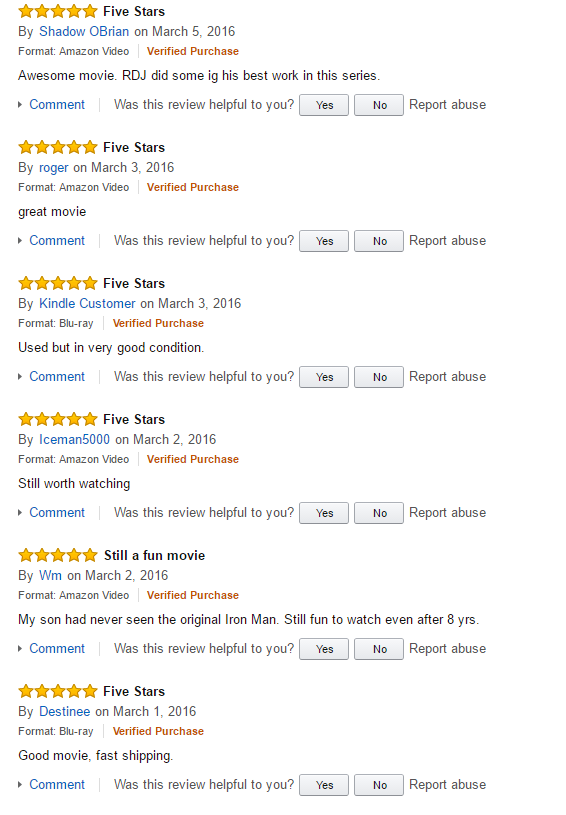

In [82]:
from IPython.display import Image
Image('F:/test/Bad Amazon Reviews.PNG')

Use the previously built table-creator on a few categories of Foursquare venues. 

Find the category list code in the following page: https://developer.foursquare.com/categorytree

In [184]:
import foursquare
import json
import pandas as pd
import unicodedata
from sklearn.preprocessing import LabelEncoder

CLIENT_ID = 'TVOZNIZN3S3J3RDQ2EMVGDYQ5B4FHIG2X2KMARCRU5DC3CZF'
CLIENT_SECRET = 'JZO43NLZJAL43HX3WKDIGVTGLWIEGNPM5ONARUTANA1UKRBM'
client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

starting_list = client.venues.search(params={'near': 'Seattle, WA', 'radius':'5000'})
print(json.dumps(starting_list, indent = 4))

{
    "confident": false, 
    "geocode": {
        "parents": [], 
        "what": "", 
        "where": "seattle wa", 
        "feature": {
            "highlightedName": "<b>Seattle</b>, <b>WA</b>, United States", 
            "displayName": "Seattle, WA, United States", 
            "name": "Seattle", 
            "longId": "72057594043737780", 
            "cc": "US", 
            "id": "geonameid:5809844", 
            "geometry": {
                "center": {
                    "lat": 47.60621, 
                    "lng": -122.33207
                }, 
                "bounds": {
                    "sw": {
                        "lat": 47.481719999999996, 
                        "lng": -122.459696
                    }, 
                    "ne": {
                        "lat": 47.734145, 
                        "lng": -122.224433
                    }
                }
            }, 
            "matchedName": "Seattle, WA, United States", 
            "woeType": 7, 
   

Load all of your venues into a dataframe. Make sure that you have at least 4-6 categories of venues included in your data so we can seperate them out later with LDA.

In [139]:
art_list = client.venues.search(params={'limit':50, 'near': 'Seattle, WA', 'radius':'5000', 'venue':i,
                                           'categoryId': '4bf58dd8d48988d130941735', ''})
art_list

{u'confident': True,
 u'geocode': {u'feature': {u'cc': u'US',
   u'displayName': u'Seattle, WA, United States',
   u'geometry': {u'bounds': {u'ne': {u'lat': 47.734145, u'lng': -122.224433},
     u'sw': {u'lat': 47.481719999999996, u'lng': -122.459696}},
    u'center': {u'lat': 47.60621, u'lng': -122.33207}},
   u'highlightedName': u'<b>Seattle</b>, <b>WA</b>, United States',
   u'id': u'geonameid:5809844',
   u'longId': u'72057594043737780',
   u'matchedName': u'Seattle, WA, United States',
   u'name': u'Seattle',
   u'slug': u'seattle-washington',
   u'woeType': 7},
  u'parents': [],
  u'what': u'',
  u'where': u'seattle wa'},
 u'venues': [{u'beenHere': {u'lastCheckinExpiredAt': 0,
    u'marked': False,
    u'unconfirmedCount': 0},
   u'categories': [{u'icon': {u'prefix': u'https://ss3.4sqi.net/img/categories_v2/building/default_',
      u'suffix': u'.png'},
     u'id': u'4bf58dd8d48988d130941735',
     u'name': u'Building',
     u'pluralName': u'Buildings',
     u'primary': True,
   

In [194]:
categories = ['4d4b7105d754a06372d81259', '4d4b7105d754a06374d81259', '4d4b7105d754a06377d81259', '4d4b7104d754a06370d81259']
ids = {}

for i in categories:
    art_list = client.venues.search(params={'limit':50, 'near': 'Seattle, WA', 'radius':'5000', 'categoryId': i})
    for j in range(len(art_list['venues'])):
        ids[art_list['venues'][j]['id']] = i
ids

{u'40b13b00f964a5204df61ee3': '4d4b7104d754a06370d81259',
 u'40b13b00f964a5205af61ee3': '4d4b7104d754a06370d81259',
 u'40b13b00f964a5207df61ee3': '4d4b7105d754a06374d81259',
 u'40b13b00f964a52084f61ee3': '4d4b7104d754a06370d81259',
 u'40b13b00f964a520c2f61ee3': '4d4b7104d754a06370d81259',
 u'40b13b00f964a520def61ee3': '4d4b7104d754a06370d81259',
 u'40b13b00f964a520ebf61ee3': '4d4b7104d754a06370d81259',
 u'40b3de00f964a52029001fe3': '4d4b7104d754a06370d81259',
 u'40b68100f964a5206e001fe3': '4d4b7104d754a06370d81259',
 u'40b7d280f964a5208d001fe3': '4d4b7104d754a06370d81259',
 u'40c8f600f964a520fd001fe3': '4d4b7104d754a06370d81259',
 u'40cf8d80f964a52026011fe3': '4d4b7104d754a06370d81259',
 u'416dc180f964a5209b1d1fe3': '4d4b7104d754a06370d81259',
 u'419a9480f964a520281e1fe3': '4d4b7105d754a06374d81259',
 u'41a91500f964a520541e1fe3': '4d4b7104d754a06370d81259',
 u'41be2d00f964a520851e1fe3': '4d4b7104d754a06370d81259',
 u'41f98080f964a5203b1f1fe3': '4d4b7104d754a06370d81259',
 u'423b6b80f96

In [195]:
comments = []
venees = []
for key, value in ids.iteritems():
    art_list = client.venues.tips(VENUE_ID=key, params={'limit':50, 'near': 'Seattle, WA', 'radius':'5000'})
    for j in range(len(art_list['tips']['items'])):
        comments.append(art_list['tips']['items'][j]['text'])
        venees.append(value)


In [196]:
venees[1][:]

'4d4b7105d754a06377d81259'

In [199]:
df = pd.concat([pd.Series(comments), pd.Series(venees)], axis=1)
df.columns = 'comment', 'class'

le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

df.head()

,comment,class
0,"On weekends you can rent a pond sailboat, whic...",3
1,There's so many great things to see all over L...,3
2,"Although they can command high prices today, t...",3
3,Watch out for the bees in the lavender bushes ...,3
4,"Check the center of the wooden boats, they hav...",3


# Constructing features using string parsing and elementary text mining

Create a normalizer function that will take the comments, lowercase all uppercase letters, split each comment into an array/list/vector of words, and remove stop words. 

In [188]:
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3            
import numpy as np
from textblob import TextBlob

Vectorize your feature set into a dense matrix representation using Countvectorizer from sklearn

A helpful reference: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [323]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest


vec = CountVectorizer(stop_words='english', token_pattern='[a-zA-Z]+', ngram_range=(1,2), max_df=0.5, min_df=3)
X = pd.DataFrame(vec.fit_transform(df.comment).todense())
X.columns = vec.get_feature_names()

y = df['class']

kbest = SelectKBest(k=970)
kbest.fit_transform(X, y)
mask = kbest.get_support()
voc = pd.DataFrame(np.asarray(vec.get_feature_names())[mask])

vec2 = CountVectorizer(vocabulary=voc[0])
X = pd.DataFrame(vec2.fit_transform(df.comment).todense())
X.columns = vec2.get_feature_names()

In [324]:
X.head()

,acoustics,active,activities,admission,adult,adults,advance,ages,air,alki,...,worth visit,worth wait,wrong,year,yo,yoga,yoga studio,yum,yummy,zip line
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Performing the LDA

Construct your LDA with the pieces above by fitting the model to your feature set and target

In [325]:
import scipy

In [326]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split


In [421]:


X_train, X_test, y_train, y_test = train_test_split(X.values, y, stratify=y, test_size=0.30, random_state=42)


lda = LDA(n_components=4)
X_r = lda.fit_transform(X,y)
print lda.score(X, y)
y_pred = lda.predict(X)


0.8009643201542912

In [432]:
from sklearn.metrics import classification_report, confusion_matrix

In [462]:
lda = LDA(n_components=4)
X_r = lda.fit_transform(X_train,y_train)
print lda.score(X_test, y_test)
y_pred = lda.predict(X_test)
print classification_report(y_test, y_pred)
confusion_matrix(y_test, y_pred)

0.723650385604
             precision    recall  f1-score   support

          0       0.64      0.83      0.72       591
          1       0.38      0.31      0.34        55
          2       0.86      0.75      0.81       576
          3       0.76      0.56      0.64       334

avg / total       0.74      0.72      0.72      1556



array([[488,  16,  48,  39],
       [ 26,  17,   3,   9],
       [123,   7, 434,  12],
       [125,   5,  17, 187]])

In [463]:
from sklearn.linear_model import LogisticRegression

In [464]:
lr = LogisticRegression()
lr.fit_transform(X_train,y_train)
print lr.score(X_test, y_test)
y_pred = lr.predict(X_test)
print classification_report(y_test, y_pred)
confusion_matrix(y_test, y_pred)


0.733933161954
             precision    recall  f1-score   support

          0       0.67      0.80      0.73       591
          1       0.75      0.11      0.19        55
          2       0.80      0.81      0.81       576
          3       0.75      0.59      0.66       334

avg / total       0.74      0.73      0.72      1556



//anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[471,   1,  77,  42],
       [ 29,   6,   9,  11],
       [ 94,   0, 469,  13],
       [107,   1,  30, 196]])

# Visualizing Results

Now print the LDA and at least a few of the categories on a 2-D discriminant chart. Do you think the method is seperating the categories very well? Should we tune it more? Would it be a good indicator of "inappropriate commenting"? 

In [465]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

# This creates random colors for your categories!
r = lambda: random.randint(0,255)
rcolor = lambda: '#%02X%02X%02X' % (r(),r(),r())



In [466]:
X_new = lda.transform(X)

In [467]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_r2 = pd.DataFrame(scaler.fit_transform(X_r))

for_the_plot = pd.concat([pd.DataFrame(X_new),y], axis=1)
for_the_plot.columns = ['c1', 'c2', 'c3', 'y']

In [468]:
for_the_plot.dropna(inplace=True)

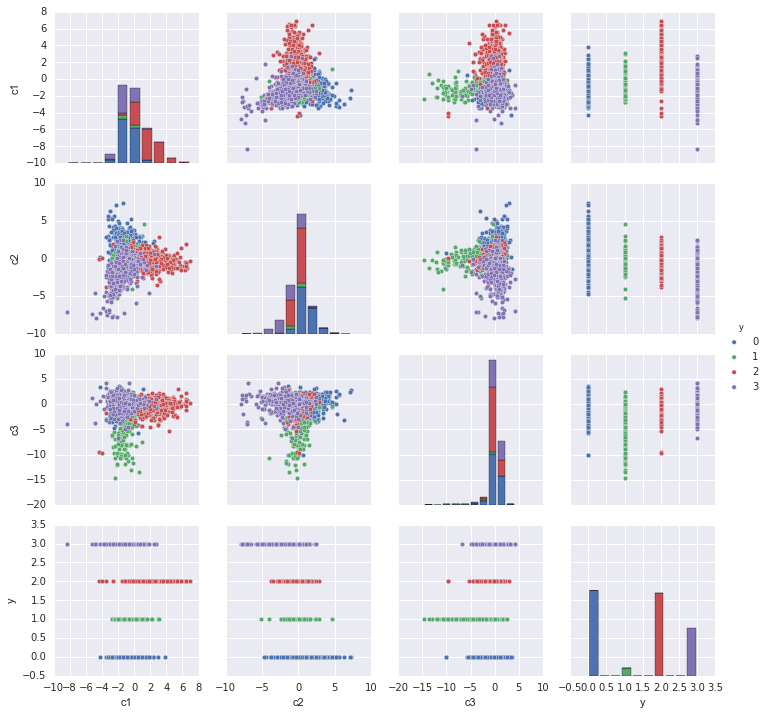

In [469]:
import seaborn as sns

sns.pairplot(for_the_plot, hue='y')